In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import pandas as pd
import json
import sys
import glob
sys.path.append("..")
sys.path.append("../src")
from prepare_echo_dataset_pn import PN_PATTERNS_1024_8

In [ ]:
results = json.load(open("results/dd_drums_pn0_0.2.json"))
results.keys()

In [ ]:
results = json.load(open("results/pnflip_drums_pn0_dur5_seed0.json"))
dur = 60
hamm = 512
t = np.concatenate(tuple(r[f"reg_0"] for r in results.values()))
f = np.concatenate(tuple(r[f"reg_{hamm}"] for r in results.values()))
print("t.size", t.size, ", f.size", f.size)
y_true = np.concatenate((np.zeros(len(f)), np.ones(len(t))))
y_score = np.concatenate((f, t))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
print("AROC", roc_auc_score(y_true, y_score))
plt.plot(fpr, tpr)

In [ ]:
results = json.load(open("results/finetune/dd_drums_pn1_0.2.json"))
dur = 60
hamm = 512+256
t = np.array([])
f = np.array([])
for key in results:
    if f"{dur}" in results[key] and "reg_0" in results[key][f"{dur}"]:
        t = np.concatenate((t, results[key][f"{dur}"]["reg_0"]))
        f = np.concatenate((f, results[key][f"{dur}"][f"reg_{hamm}"]))
print("t.size", t.size, ", f.size", f.size)
y_true = np.concatenate((np.zeros(len(f)), np.ones(len(t))))
y_score = np.concatenate((f, t))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
print("AROC", roc_auc_score(y_true, y_score))
plt.plot(fpr, tpr)

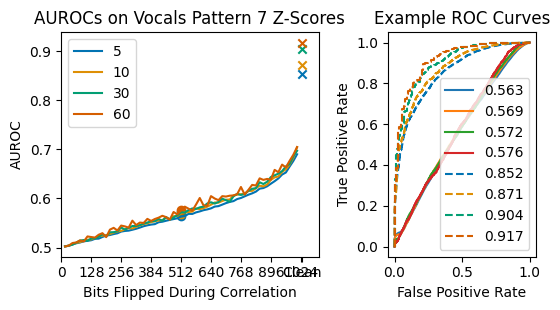

In [2]:
CLEAN_SPOT = 1030

colors = sns.color_palette("colorblind", 4)

fac = 0.8
plt.figure(figsize=(fac*7, fac*4))
all_results_rave = {}
examples_to_plot = {5:512, 10:512, 30:512, 60:512}
durs = [5, 10, 30, 60]
for instrument in ["drums", "other", "vocals"]:
    for pn in range(8):
        all_results_rave[(instrument, pn)] = {}
        plt.clf()
        plt.subplot2grid((1, 5), (0, 0), colspan=3, rowspan=1)
        for duridx, dur in enumerate(durs):
            ## Step 1: Plot AUROC for all perturbations
            results = {}
            #print("pattern", f"results/pnflip_{instrument}_pn{pn}_dur{dur}*.json")
            for f in glob.glob(f"results/pnflip_only/pnflip_{instrument}_pn{pn}_dur{dur}_seed*.json"):
                #print(f)
                resultsf = json.load(open(f))
                for tune in resultsf.values():
                    for key, value in tune.items():
                        if not key in results:
                            results[key] = tune[key]
                        else:
                            results[key] = np.concatenate((results[key], value))
            t = results[f"reg_0"]
            hamm = []
            for key in results:
                prefix = "reg_"
                if prefix in key:
                    hamm.append(int(key[len(prefix):]))
            hamm = np.sort(np.array(hamm))[1:]
            aurocs = np.zeros(hamm.size)
            aurocs_by_hamm = {}
            for i, h in enumerate(hamm):
                f = results[f"reg_{h}"]
                y_true = np.concatenate((np.zeros(len(f)), np.ones(len(t))))
                y_score = np.concatenate((f, t))
                fpr, tpr, thresholds = roc_curve(y_true, y_score)
                auroc = roc_auc_score(y_true, y_score)
                all_results_rave[(instrument, pn)][(dur, h)] = (fpr, tpr, auroc)
                #if i == 0:
                #    print("pn", pn, ", dur", dur, "t.size", t.size, ", f.size", f.size)
                aurocs[i] = auroc
                aurocs_by_hamm[h] = auroc
            plt.plot(hamm, aurocs, label=f"{dur}", c=colors[duridx])
            h = examples_to_plot[dur]
            plt.scatter(h, aurocs_by_hamm[h], c=np.array(colors[duridx])[None, :], label="_nolegend_")
            
    
    
            ## Step 2: See what the clean model had to say
            res_clean = json.load(open(f"results/rave_{instrument}_pnclean_seed0.json"))
            f = np.array([])
            for key in res_clean:
                if len(res_clean[key][f"{dur}"]) > 0:
                    f = np.concatenate((f, res_clean[key][f"{dur}"][f"reg_pn{pn}"]))
            y_true = np.concatenate((np.zeros(len(f)), np.ones(len(t))))
            y_score = np.concatenate((f, t))
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            auroc = roc_auc_score(y_true, y_score)
            all_results_rave[(instrument, pn)][(dur, "clean")] = (fpr, tpr, auroc)
            plt.scatter(CLEAN_SPOT, auroc, c=np.array(colors[duridx])[None, :], marker='x', label="_nolegend_")
    
            
            """
            ## Step 2: Plot AUROC from other models
            for pn_other in range(8):
                if pn_other == pn:
                    continue
                res = json.load(open(f"results/rave_{instrument}_pn{pn_other}_seed0.json"))
                f = np.array([])
                for key in res:
                    if len(res[key][f"{dur}"]) > 0:
                        f = np.concatenate((f, res[key][f"{dur}"][f"reg_pn{pn}"]))
                y_true = np.concatenate((np.zeros(len(f)), np.ones(len(t))))
                y_score = np.concatenate((f, t))
                auroc = roc_auc_score(y_true, y_score)
                hamm = np.sum(np.abs(PN_PATTERNS_1024_8[pn]-PN_PATTERNS_1024_8[pn_other]))
                print(pn, pn_other, hamm)
                plt.scatter(hamm, auroc, c=f"C{duridx}", label="_nolegend_")
            """
                
        
        
        instrument_name = {"drums":"Drums", "other":"Guitar", "vocals":"Vocals"}[instrument]
        plt.xlabel("Bits Flipped During Correlation")
        plt.ylabel("AUROC")
        plt.title(f"AUROCs on {instrument_name} Pattern {pn} Z-Scores")
        plt.legend([f"{d}" for d in durs])
        ticks = list(range(0, 1025, 128)) + [CLEAN_SPOT]
        ticksplt = [tck for tck in ticks]
        ticksplt[-1] = "Clean"
        plt.xticks(ticks, ticksplt)
        plt.xlim([0, 1100])
        plt.legend(["5", "10", "30", "60"])
    
    
    
        plt.subplot2grid((1, 5), (0, 3), colspan=2, rowspan=1)
        legend = []
        for dur, hamm in examples_to_plot.items():
            (fpr, tpr, auroc) = all_results_rave[(instrument, pn)][(dur, hamm)]
            legend.append("{:.3f}".format(auroc))
            plt.plot(fpr, tpr)
        for i, dur in enumerate(durs):
            (fpr, tpr, auroc) = all_results_rave[(instrument, pn)][(dur, "clean")]
            plt.plot(fpr, tpr, linestyle='--', c=colors[i])
            legend.append("{:.3f}".format(auroc))
        plt.legend(legend)
        plt.tight_layout()
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Example ROC Curves")
    
        plt.tight_layout()
        if instrument == "drums" and pn == 0:
            plt.savefig(f"../Writeup/figs/{instrument_name}PNModel_pn{pn}.svg", bbox_inches='tight')
        else:
            plt.savefig(f"../Writeup/figs/other/{instrument_name}PNModel_pn{pn}.svg", bbox_inches='tight')



In [14]:
res = json.load(open("results/ddsp_vocals_pnclean_seed0.json"))
res['Steven Clark - Bounty']['10'].items()

dict_items([('reg_pn0', [-1.2651886383052653, -1.1864240735184204, -0.4576500606405545, -0.6563311915547572, -0.814933109924993, -0.48957564693866745, -0.19368248343370936, -1.00678250550849, 0.1825762966009066, -0.8348375757756832, -1.0950186460168014, -1.0014603785391651]), ('enhanced_pn0', [-1.0638005925982976, -1.0867404544973003, -0.4805299613991866, -0.6957316958018358, -0.6890599091788511, -0.8473628506420149, -0.46197114584489185, -0.8534259431323356, -0.2634844918918498, -0.7026098150298257, -1.0217204025336863, -0.8077690939496979]), ('reg_pn1', [-0.6871103594949656, -0.5990454159955546, -0.23328185948069852, -0.2684448104130477, -0.1520846664200512, -0.10966417245801813, 0.27746199518555315, -0.5296675549594393, 0.35952758390764333, -0.2932252235000614, -0.5138774756269525, -0.266410317721772]), ('enhanced_pn1', [-0.4563284393789867, -0.506395085808686, -0.21202400384094827, -0.2510399561670927, -0.1386837697824866, -0.3301936383606863, 0.10910664593052505, -0.45476454424640

In [3]:
all_results_ddsp = {}
durs = [5, 10, 30, 60]
for instrument in ["drums", "other", "vocals"]:
    for pn in range(8):
        all_results_ddsp[(instrument, pn)] = {}
        ## Step 1: Plot AUROC for all perturbations
        results = {dur:{} for dur in durs}
        #print("pattern", f"results/pnflip_{instrument}_pn{pn}_dur{dur}*.json")
        for f in glob.glob(f"results/ddsp_{instrument}_pn{pn}_seed*.json"):
            #print(f)
            resultsf = json.load(open(f))
            for tune in resultsf.values():
                for dur in durs:
                    for key, value in tune[f"{dur}"].items():
                        if not key in results[dur]:
                            results[dur][key] = value
                        else:
                            results[dur][key] = np.concatenate((results[dur][key], value))
        for dur in durs:
            t = results[dur][f"reg_0"]
            hamm = []
            for key in results[dur]:
                prefix = "reg_"
                if prefix in key and not "pn" in key:
                    hamm.append(int(key[len(prefix):]))
            hamm = np.sort(np.array(hamm))[1:]
            aurocs = np.zeros(hamm.size)
            aurocs_by_hamm = {}
            for i, h in enumerate(hamm):
                f = results[dur][f"reg_{h}"]
                y_true = np.concatenate((np.zeros(len(f)), np.ones(len(t))))
                y_score = np.concatenate((f, t))
                fpr, tpr, thresholds = roc_curve(y_true, y_score)
                auroc = roc_auc_score(y_true, y_score)
                all_results_ddsp[(instrument, pn)][(dur, h)] = (fpr, tpr, auroc)
                #if i == 0:
                #    print("pn", pn, ", dur", dur, "t.size", t.size, ", f.size", f.size)
                aurocs[i] = auroc
                aurocs_by_hamm[h] = auroc
        


            ## Step 2: See what the clean model had to say
            res_clean = json.load(open(f"results/rave_{instrument}_pnclean_seed0.json"))
            f = np.array([])
            for tune in res_clean:
                for key, value in res_clean[tune][f"{dur}"].items():
                    if len(value) > 0:
                        f = np.concatenate((f, value))
            y_true = np.concatenate((np.zeros(len(f)), np.ones(len(t))))
            y_score = np.concatenate((f, t))
            fpr, tpr, thresholds = roc_curve(y_true, y_score)
            auroc = roc_auc_score(y_true, y_score)
            all_results_ddsp[(instrument, pn)][(dur, "clean")] = (fpr, tpr, auroc)
    

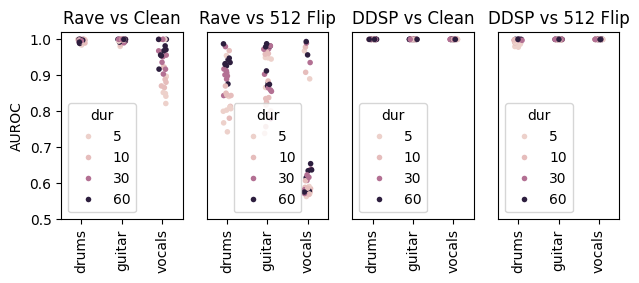

In [8]:
d = dict(dataset=[], auroc512=[], aurocclean=[], dur=[])

fac = 0.9
plt.figure(figsize=(fac*8, fac*2.7))
instrument_label = {"drums":"drums", "other":"guitar", "vocals":"vocals"}
for instrument in ["drums", "other", "vocals"]:
    for pn in range(8):
        for duridx, dur in enumerate(durs):
            d["dataset"].append(instrument_label[instrument])
            d["auroc512"].append(all_results_rave[(instrument, pn)][(dur, 512)][-1])
            d["aurocclean"].append(all_results_rave[(instrument, pn)][(dur, "clean")][-1])
            d["dur"].append(dur)
ylim = [0.5, 1.02]
plt.subplot(141)
sns.stripplot(data=pd.DataFrame(data=d), x="dataset", y="aurocclean", hue="dur", size=4)
plt.ylim(ylim)
plt.ylabel("AUROC")
plt.xlabel("")
plt.title("Rave vs Clean")
plt.xticks(rotation=90)
plt.subplot(142)
sns.stripplot(data=pd.DataFrame(data=d), x="dataset", y="auroc512", hue="dur", size=4)
plt.ylim(ylim)
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=90)
plt.title("Rave vs 512 Flip")


d = dict(dataset=[], auroc512=[], aurocclean=[], dur=[])
for instrument in ["drums", "other", "vocals"]:
    for pn in range(8):
        for duridx, dur in enumerate(durs):
            d["dataset"].append(instrument_label[instrument])
            d["auroc512"].append(all_results_ddsp[(instrument, pn)][(dur, 512)][-1])
            d["aurocclean"].append(all_results_ddsp[(instrument, pn)][(dur, "clean")][-1])
            d["dur"].append(dur)
ylim = [0.5, 1.02]
plt.subplot(143)
sns.stripplot(data=pd.DataFrame(data=d), x="dataset", y="aurocclean", hue="dur", size=4)
plt.ylim(ylim)
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.xticks(rotation=90)
plt.title("DDSP vs Clean")
plt.subplot(144)
sns.stripplot(data=pd.DataFrame(data=d), x="dataset", y="auroc512", hue="dur", size=4)
plt.ylim(ylim)
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=90)
plt.title("DDSP vs 512 Flip")
plt.savefig("../Writeup/figs/PNEval.svg", bbox_inches='tight')